# Variational Autoencoder
Build a variational autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [4]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Variational Autoencoder
Build the variational autoencoder. First, we will create a custom function to sample the mean and log-variables.

In [128]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [129]:
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [130]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder.summary()
variational_decoder.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 784)          0           input_24[0][0]                   
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 150)          117750      flatten_12[0][0]                 
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 100)          15100       dense_81[0][0]                   
___________________________________________________________________________________________

In [131]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3906 - rounded_accuracy: 0.8601 - val_loss: 0.3469 - val_rounded_accuracy: 0.8886
Epoch 2/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3426 - rounded_accuracy: 0.8980 - val_loss: 0.3382 - val_rounded_accuracy: 0.8932
Epoch 3/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3330 - rounded_accuracy: 0.9050 - val_loss: 0.3313 - val_rounded_accuracy: 0.9011
Epoch 4/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3236 - val_rounded_accuracy: 0.9089
Epoch 5/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3248 - rounded_accuracy: 0.9118 - val_loss: 0.3219 - val_rounded_accuracy: 0.9155
Epoch 6/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3226 - rounded_accuracy: 0.9137 - val_loss:

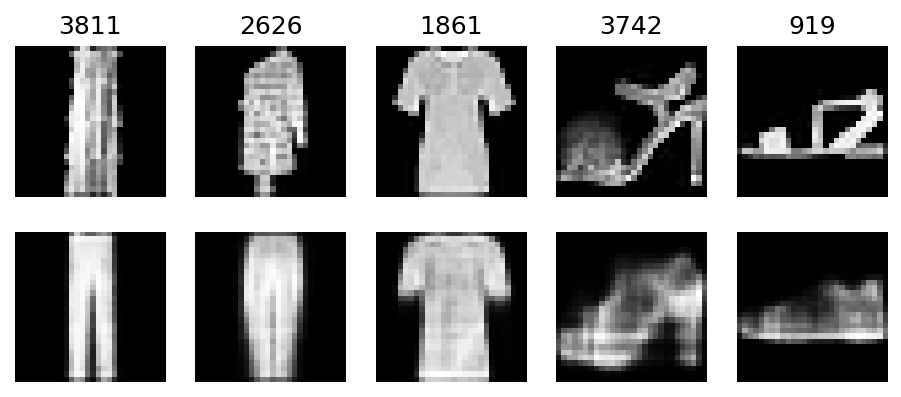

In [132]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 5)
plot_reconstructions(variational_ae, index_list, X_valid)

In [150]:
X_valid_vae_encoded = variational_encoder.predict(X_valid, batch_size=128)

In [151]:
np.shape(X_valid_vae_encoded)

(3, 5000, 10)

## 3.0 Disentangled Variational Autoencoder

In [135]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [388]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10
beta_value = 1

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder_beta = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder_beta = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder_beta(inputs)
reconstructions = variational_decoder_beta(codings)
variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * beta_value * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae_beta.add_loss(K.mean(latent_loss) / 784.)
variational_ae_beta.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder_beta.summary()
variational_decoder_beta.summary()


# make tensorboard callback and name folder
log_dir="logs/" + str('vae_') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
                                                      update_freq='epoch',profile_batch=0)

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 784)          0           input_40[0][0]                   
__________________________________________________________________________________________________
dense_137 (Dense)               (None, 150)          117750      flatten_20[0][0]                 
__________________________________________________________________________________________________
dense_138 (Dense)               (None, 100)          15100       dense_137[0][0]                  
___________________________________________________________________________________________

In [389]:
history = variational_ae_beta.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid],callbacks=[tensorboard_callback])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 62us/sample - loss: 0.3909 - rounded_accuracy: 0.8599 - val_loss: 0.3461 - val_rounded_accuracy: 0.8944
Epoch 2/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3428 - rounded_accuracy: 0.8979 - val_loss: 0.3332 - val_rounded_accuracy: 0.9018
Epoch 3/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3330 - rounded_accuracy: 0.9052 - val_loss: 0.3270 - val_rounded_accuracy: 0.9080
Epoch 4/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3281 - rounded_accuracy: 0.9090 - val_loss: 0.3243 - val_rounded_accuracy: 0.9071
Epoch 5/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3249 - rounded_accuracy: 0.9118 - val_loss: 0.3225 - val_rounded_accuracy: 0.9142
Epoch 6/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3227 - rounded_accuracy: 0.9135 - val_loss:

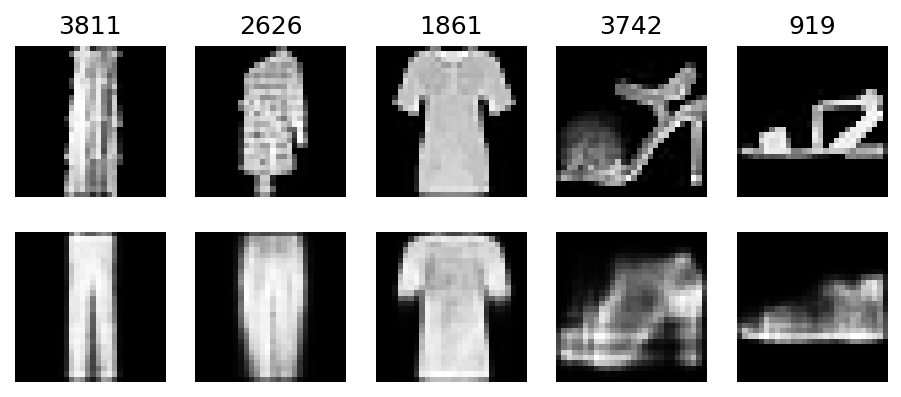

In [390]:
plot_reconstructions(variational_ae_beta, index_list, X_valid)

Let's try and cluster some of the results...

In [183]:
# check out variational encoder
variational_encoder_beta

In [312]:
X_valid_encoded = variational_encoder_beta.predict(X_valid, batch_size=128)

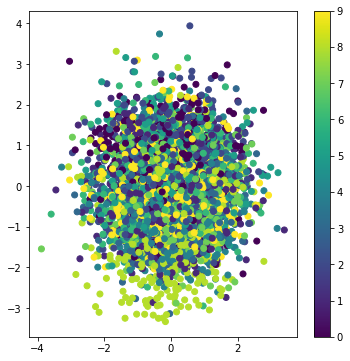

In [313]:
plt.figure(figsize=(6,6))
plt.scatter(X_valid_encoded[2][:,0], X_valid_encoded[2][:,1], c=y_valid)
plt.colorbar()
plt.show()

In [314]:
X_valid_encoded[2][:,0]

array([ 0.09819393,  0.5643421 , -1.090238  , ..., -0.6623277 ,
       -0.34501684, -1.2590743 ], dtype=float32)

In [315]:
# try to use T-SNE
# code from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

np.random.seed(63)

from sklearn.manifold import TSNE

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_encoded[2][:,:])
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

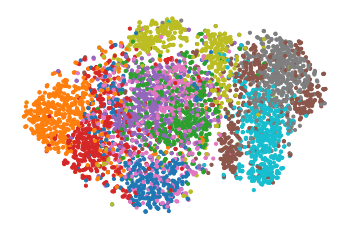

In [316]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Try and recreate some image like in the Beta-VAE original paper...

In [192]:
X_bvae_encoder = np.array(X_valid_encoded[2])

In [337]:
y_valid

array([9, 0, 0, ..., 5, 8, 3], dtype=uint8)

In [193]:
np.shape(X_bvae_encoder)

(5000, 10)

In [392]:
X_valid_codings = variational_encoder_beta(X_valid)[2].numpy()

In [317]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [393]:
d = {}

for i in np.arange(0,10, dtype='uint8'):
    print(i)
    d[i] = np.zeros(10)


0
1
2
3
4
5
6
7
8
9


In [394]:
for i, yi in enumerate(y_valid):
    d[yi] = np.vstack((d[yi],X_valid_codings[i]))

In [469]:
d[0][1]

array([ 0.59186924,  0.43495435,  0.5060938 ,  1.1485163 , -0.80633259,
       -1.63310707,  0.61806548, -2.31405544,  1.37660193,  0.79458463])

In [440]:
t=np.reshape(np.mean(d[3],axis=0),(1,-1))
np.shape(t)

(1, 10)

In [441]:
reconstruction_i = variational_decoder_beta(t)

In [433]:
z_sample=np.array([[0,0,0,0,0,0,0,0,0,0]])
x_decoded=variational_decoder_beta(z_sample)
z_sample.shape

(1, 10)

In [630]:
random.randint(1,101)

54

In [580]:
[10]*10

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]

In [755]:
def plot_mean_z(d, variational_decoder_beta,class_names):
    
    # Customize grid with gridspec http://bit.ly/2MkqRWZ
    gs_kw = dict(width_ratios=[6,1,1], height_ratios=[8]*10,wspace=0.05,hspace=0.1)
    
    
    fig, axes = plt.subplots(nrows=10,ncols=3,figsize=(7,7),dpi=150,constrained_layout=False, gridspec_kw=gs_kw)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    fig.suptitle("Average Latent Variables and their Reconstructions")

    for i in range(0, 10):       
        
        z_latent_mean = np.reshape(np.mean(d[i],axis=0),(1,-1))
        z_latent_example = np.reshape(d[i][random.randint(1,len(d[i]))],(1,-1))
        reconstruction_mean = variational_decoder_beta(z_latent_mean)
        reconstruction_example = variational_decoder_beta(z_latent_example)
        
        axes[i][0].bar(x=range(0,10),height=np.reshape(z_latent_mean,(-1)))
        axes[i][0].set_ylim((-2.5,2.5))
#         axes[i][0].axis('off')

        # format parameters
        x_labels = [0,1,2,3,4,5,6,7,8,9]
        y_axis_label = "Class " + str(i) + "\n" + class_names[i]
        axes[i][0].set_yticks([])
        axes[i][0].tick_params(bottom=False, left=False)
#         axes[i][0].get_yaxis().set_visible(False)
        axes[i][0].get_xaxis().set_ticks(x_labels)
        axes[i][0].set_xticklabels(labels=x_labels,fontsize=8)
        axes[i][0].set_ylabel(y_axis_label,fontsize=5)
        axes[i][0].spines["top"].set_visible(False)
        axes[i][0].spines["right"].set_visible(False)
        axes[i][0].spines["left"].set_visible(False)
        
        if i == 0:
            axes[i][0].set_title("Average Latent Variables", fontsize=5)
            axes[i][1].set_title("Average Latent\nVariable\nReconstruction", fontsize=5)
            axes[i][2].set_title("Random Example\nfrom Data Set\nReconstruction", fontsize=5)
        else:
            pass
            
        if i == 9:
             #  label chart and axis
            axes[i][0].set_xlabel('Latent Variable, z', fontsize=8)
        
        if i != 9:
            axes[i][0].spines["bottom"].set_visible(False)
            
           
        else:
            pass
#         axes[0][i].set_title(str(index_list[i]))
        
              
    
        # mean latent variable reconstruction
        axes[i][1].imshow(np.reshape(reconstruction_mean,[28,28]), cmap='viridis',)
        axes[i][1].axis('off')
        
        # example of a single reconstruction
        axes[i][2].imshow(np.reshape(reconstruction_example,[28,28]), cmap='viridis')
        axes[i][2].axis('off')
        
        # label chart and axis
        
#     plt.title("Average Latent Variables and their Reconstructions")
    plt.show()

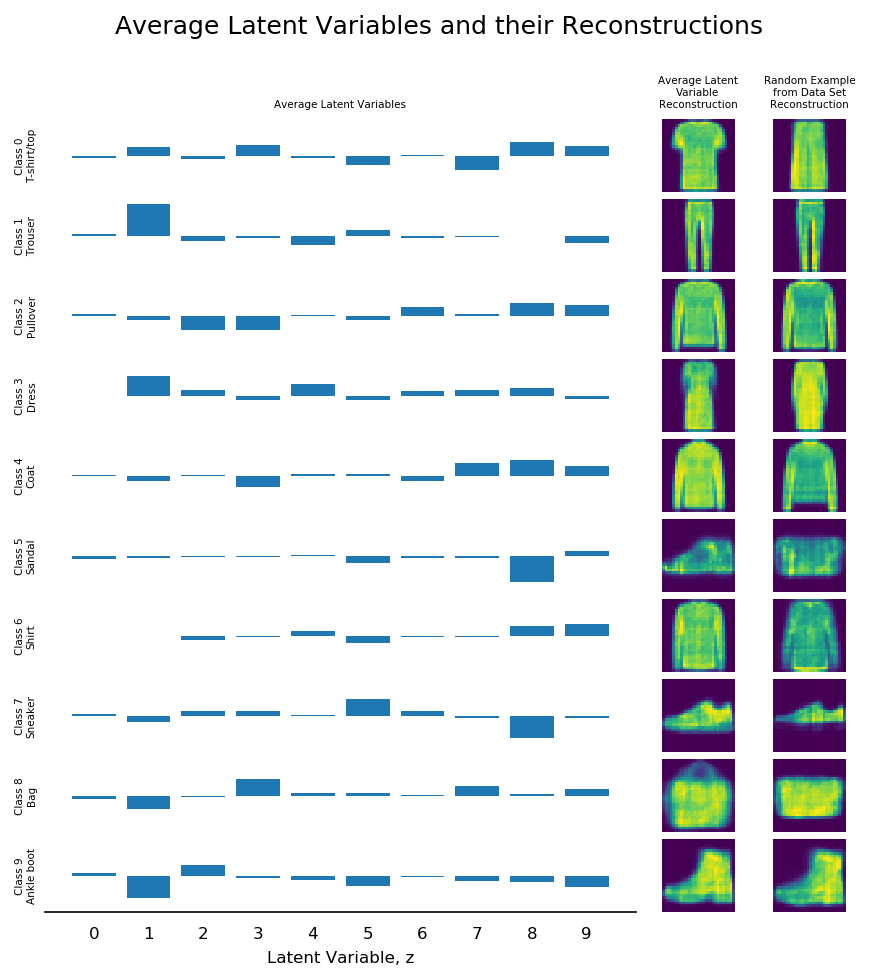

In [756]:
plot_mean_z(d, variational_decoder_beta, class_names)

In [689]:
plot_mean_z(d)

TypeError: plot_mean_z() missing 2 required positional arguments: 'variational_decoder_beta' and 'class_names'

In [347]:
t = np.vstack((d[0],np.zeros(10)))

In [348]:
np.shape(t)

(2, 10)

In [334]:
d

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [332]:
d

{1: 'test'}

In [320]:
# create a dictionary to store all the 

for i, zi in enumerate(X_valid_codings):
    print(zi)

[-0.8309397  -1.1680287   0.81512696 -0.4757324  -1.6675683  -0.10449008
 -3.0517974  -0.76569563 -0.6033771   0.02209834]
[ 0.15358244  1.6035218   0.12670201 -0.30834883 -0.8702411  -1.4409709
 -1.0639592  -0.6811226   1.3940731   0.12560904]
[-0.26703355  0.16268632 -0.01757875 -0.1824566   1.405562   -0.69693816
 -0.24672636  0.99099934  0.5901067  -0.34867263]
[-1.194287   -0.2821878   0.418179   -1.6098969   0.6247353  -0.8829025
  0.0118371   0.71337205  0.71885073 -0.56887245]
[ 0.2568882  -0.8173559   1.4660782   0.6259357   0.90847874 -0.9499971
  0.98935527 -0.7688737   1.533753    0.6878214 ]
[-0.93147     1.0491244   0.6218337  -1.4994799  -0.74061847  1.1655648
  0.19475134  0.19475734  0.2968809   0.26243556]
[-0.09184369 -0.6279     -0.24777101  0.8638113   0.9512191   0.49501014
 -0.74914706 -1.5689571  -1.8404652  -0.47253522]
[-0.72973853  1.2503136  -1.3687     -1.0241957  -1.9268208   1.3994156
  0.38223118 -1.2505393  -0.10386699 -0.72644556]
[-0.7144383   0.97527

 -2.2252722   0.12349868 -2.5691988   0.1496526 ]
[-1.915174   -0.99242795 -2.2824383   0.45622778  0.2880866  -0.68164456
 -1.1395481  -0.86558026  2.4278908  -0.21294358]
[ 0.8153685   0.32050428  1.6277784   0.6338857   0.11358777  2.0174263
 -0.16905376  0.38078323  0.2137783  -1.4362178 ]
[-0.39307985 -3.2820487  -0.75958693  2.0831833  -0.55002266 -0.44226602
  0.80682766  1.2406676   0.18738979  0.03253704]
[-0.295649   -0.3830692   0.15832537 -0.33563828 -0.56716454  1.6303406
 -1.8345264  -1.8333889  -0.97610146  0.7567172 ]
[-0.22235595  1.1784059  -0.17482522  2.6055307   1.383744    0.71536934
  0.6732039  -0.40232292 -1.3339012   1.1943177 ]
[ 0.17693786  1.05673     1.2057136  -1.5834355  -1.0501477  -0.31989372
  0.8267872   0.2582902   2.0650327   2.2712445 ]
[-0.6006204   0.21410248  0.6658768   0.22008385  1.6006222   1.6550645
 -0.97105044 -0.14325982  1.3084505  -0.07607955]
[ 0.9048082   0.7096846   0.9272644  -0.38603044 -2.2250896  -0.37486008
  0.24070126 -0.869

 -1.5580842   1.0446906   0.611709    0.5694207 ]
[-0.6958335   0.3899143  -1.7939973   0.02511175  2.2903252  -1.1673521
  1.2163682   1.292036    1.3343596  -0.16318995]
[-0.09200314  1.8218291   0.21365377  0.36459833  0.62966186 -0.13351452
  0.8706137   0.2642481  -1.3954669  -0.12265246]
[-1.253818    1.7077557   1.145762    0.55321056 -0.60482913  1.0020294
 -1.5033772  -1.3238429  -0.10101318 -1.5514345 ]
[ 1.0319407   1.2417389  -0.352975   -1.2523067   2.756204    0.38265336
  0.6001159  -1.5154831   0.55619866  1.5928497 ]
[-0.03746352  0.6436995  -1.2682444   0.98464745  1.7843485   0.5489679
  0.9284899  -1.7006263  -1.4832832   1.5001224 ]
[ 5.2074695e-01  8.9852208e-01 -5.2461392e-01  2.9722616e-01
 -5.4635006e-01 -9.3159169e-02  1.1755209e+00 -2.4820387e+00
 -1.0205882e+00 -9.9837780e-06]
[-1.483865   -0.5286056   0.6148496   0.5230278  -0.07824636 -1.4229274
 -0.81150985  0.7362504  -0.04761381 -1.800242  ]
[-0.43286574  0.16794226 -1.1676811   1.201931   -1.585619   -

  0.6785334   0.894534   -1.3281746   0.8793783 ]
[ 0.5562509   0.2940144   1.8424597   2.0075457  -1.7548631  -0.11639358
  0.55060846  0.25391838 -0.03976287  1.7246397 ]
[-2.6783724   0.1888378   1.0220954  -1.31054     0.44403726  0.4417411
  0.74689645  1.318618    0.19885238 -1.2601453 ]
[-2.1798277  -1.2357779  -0.42316163 -1.2866758  -0.6691051   1.1796788
 -0.7302297  -0.7411907   1.2792329   0.56020033]
[ 0.10475548 -0.14770973 -0.21978869 -0.90652996 -0.14057216  0.27416983
 -1.6557083  -0.66332275  0.5165851  -0.944786  ]
[-0.02374847 -0.75407606 -0.3542422  -0.19417447  0.13608271  0.9273319
  1.3410589   0.22037601  0.33147326 -0.20438154]
[-1.5042479   0.31634563 -1.7231631  -0.13586399 -0.9521882  -1.7300084
 -0.285244   -0.13453494 -0.29889166  1.3810118 ]
[ 2.0073988e-03  2.3173862e+00 -4.0131617e-01 -3.3068630e-01
 -1.4771491e-01  5.4426134e-01 -1.8654409e-01  8.1576729e-01
 -3.9222074e-01 -7.6869804e-01]
[-0.9210549  -0.5979425  -0.35513908  1.5052489  -0.56145334  

  2.3789673   0.39134967 -0.23806089 -2.5861626 ]
[ 0.3891071  -1.4113765   0.82619977 -1.2646672   0.2007844  -0.58153355
 -0.5931502   0.46277943  0.5191244   1.829193  ]
[-0.74642974  2.032737   -0.8385978  -0.00701039 -1.2056766   1.6691581
  0.79095346 -0.00682795  0.49044526  1.8885428 ]
[ 0.2866036  -1.1804401   0.9795428   2.6818244  -0.37542254  1.076918
 -0.6929266   1.8929839   0.27480024  1.4157369 ]
[-0.7737952  -1.4453201  -0.5865562   1.8053944   0.05666395 -0.11447521
  1.4898841  -0.6519632   1.7937818  -0.6975309 ]
[-0.3238278  -0.9446784   0.43273342  2.2326841  -1.1938285  -1.1201043
  0.1051218   0.08290118 -0.8606266  -0.5681741 ]
[ 1.022006    0.30605885 -0.1342667  -0.094654   -1.3436518  -0.3441955
 -0.39136997  0.40766683 -1.7574167   1.5791645 ]
[ 0.3869601  -0.13596198 -0.17985058 -1.0978166  -0.19995584 -0.21279335
 -1.1015123   0.4854143   1.5952127  -0.98013854]
[ 0.21487984  2.2106712   0.45472485 -0.16729954 -0.05355448  2.3033078
 -1.2443469  -0.095154

  0.7896596   0.42922506  0.02284814 -1.2041156 ]
[-1.8365089   0.45356506  0.74984086  0.46280622 -0.5535     -0.834864
  1.5245012  -0.11716285 -0.50892067  0.65727174]
[-0.3246417  -0.31858158  1.3269391   0.27205855 -0.04151115  0.415795
 -0.1370785  -1.5102262   0.8631615  -0.2821938 ]
[-1.3187971  -1.2256935   0.02450311 -0.9714964   0.5541123   0.80747646
  1.7421159   0.3755232  -1.4147604   0.608594  ]
[ 0.8810608   1.2186553  -2.781365   -0.2990514  -0.10047056  0.0705446
 -1.2766674  -0.72604716  0.6544243   2.6989577 ]
[ 0.67007005 -0.86548203 -0.06671706  0.3198884   2.2319613  -1.4590743
  1.2823476  -2.3299968  -0.08907233  0.12251431]
[-1.4650673   0.1536612  -1.549023    1.0374105   2.1350243   0.33182895
  1.1726415   0.45469272  0.02017194 -0.03110793]
[ 2.1378605   0.74536425 -2.651097   -0.27253535 -1.3709269   0.87944424
  0.5526883  -0.506504    0.50313115 -1.2735192 ]
[ 0.85890067  0.2639197  -0.2622589  -1.644804   -2.1103423   0.7158544
 -2.4479482   0.3974917

[ 0.01642973 -1.5368159   0.31678832 -1.3172435   0.04738438  0.91203153
 -1.4696051  -0.28171986 -0.12107385 -0.9565762 ]
[-1.3818768  -0.43791142 -1.4713655   0.15676169 -0.32002702  0.49450862
  0.05363356  1.9902258   0.41855788 -0.5576557 ]
[-0.14786737  0.24314123  0.03546318  0.22445337 -1.3363988  -0.69771963
 -0.4615894  -0.58431137 -1.3937542  -0.726176  ]
[-1.5759411  -0.48441166  1.0705813  -0.49223125 -0.21284917  0.17071033
  1.2244548  -0.4508617   1.5900294  -0.20449835]
[-0.9316975  -0.69487745  1.050469   -0.07703878  0.36136803  1.0184312
 -0.70446515 -0.9852856  -2.1688888  -0.07935128]
[ 1.1566488  -0.7380272  -1.0040812  -0.41429812 -2.208258   -0.0066122
  0.8862373  -1.1726284  -1.5532889   1.1155627 ]
[ 0.22487374  0.41202638 -0.8728517   0.48734862 -0.07710026  0.17425197
  1.2878146   2.1470103  -0.42752635 -0.8028675 ]
[ 1.1028807  -1.0861491   0.40265888  0.8421654   1.8235149   0.45192242
 -1.64314     2.0597835   0.59579164  1.7749791 ]
[ 1.0053481  -1.36

In [198]:
# plots from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid)[2].numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])


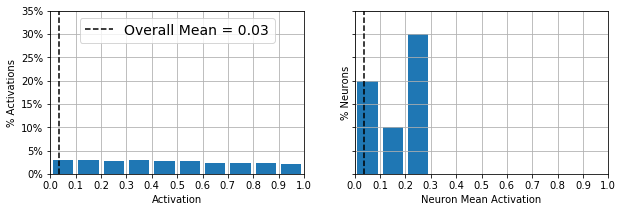

In [207]:
plot_activations_histogram(variational_encoder_beta, height=0.35)
plt.show()

In [284]:
X_valid_codings = variational_encoder_beta(X_valid)[2].numpy()

In [285]:
np.shape(X_valid_codings)

(5000, 10)

In [286]:
y_valid

array([9, 0, 0, ..., 5, 8, 3], dtype=uint8)

In [287]:
decoder_inputs

<tf.Tensor 'input_39:0' shape=(None, 10) dtype=float32>

In [288]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[1, codings_size])

In [289]:
codings

<tf.Tensor: id=1758028, shape=(1, 10), dtype=float32, numpy=
array([[ 0.3274685 , -0.8426258 ,  0.3194337 , -1.4075519 , -2.3880599 ,
        -1.0392479 , -0.5573232 ,  0.539707  ,  1.6994323 ,  0.28893656]],
      dtype=float32)>

In [290]:
codings_zero = np.zeros((1,10), dtype='float32')
print(codings_zero)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(-0.5, 27.5, 27.5, -0.5)

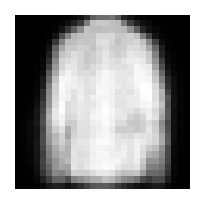

In [291]:
tf.random.set_seed(15)

# codings = tf.random.normal(shape=[1, codings_size])

img = variational_decoder_beta(codings_zero)

fig, axes = plt.subplots(1, 1,figsize=(1.5,3),dpi=150)
axes.imshow(np.reshape(img,[28,28]), cmap='Greys_r')
axes.axis('off')

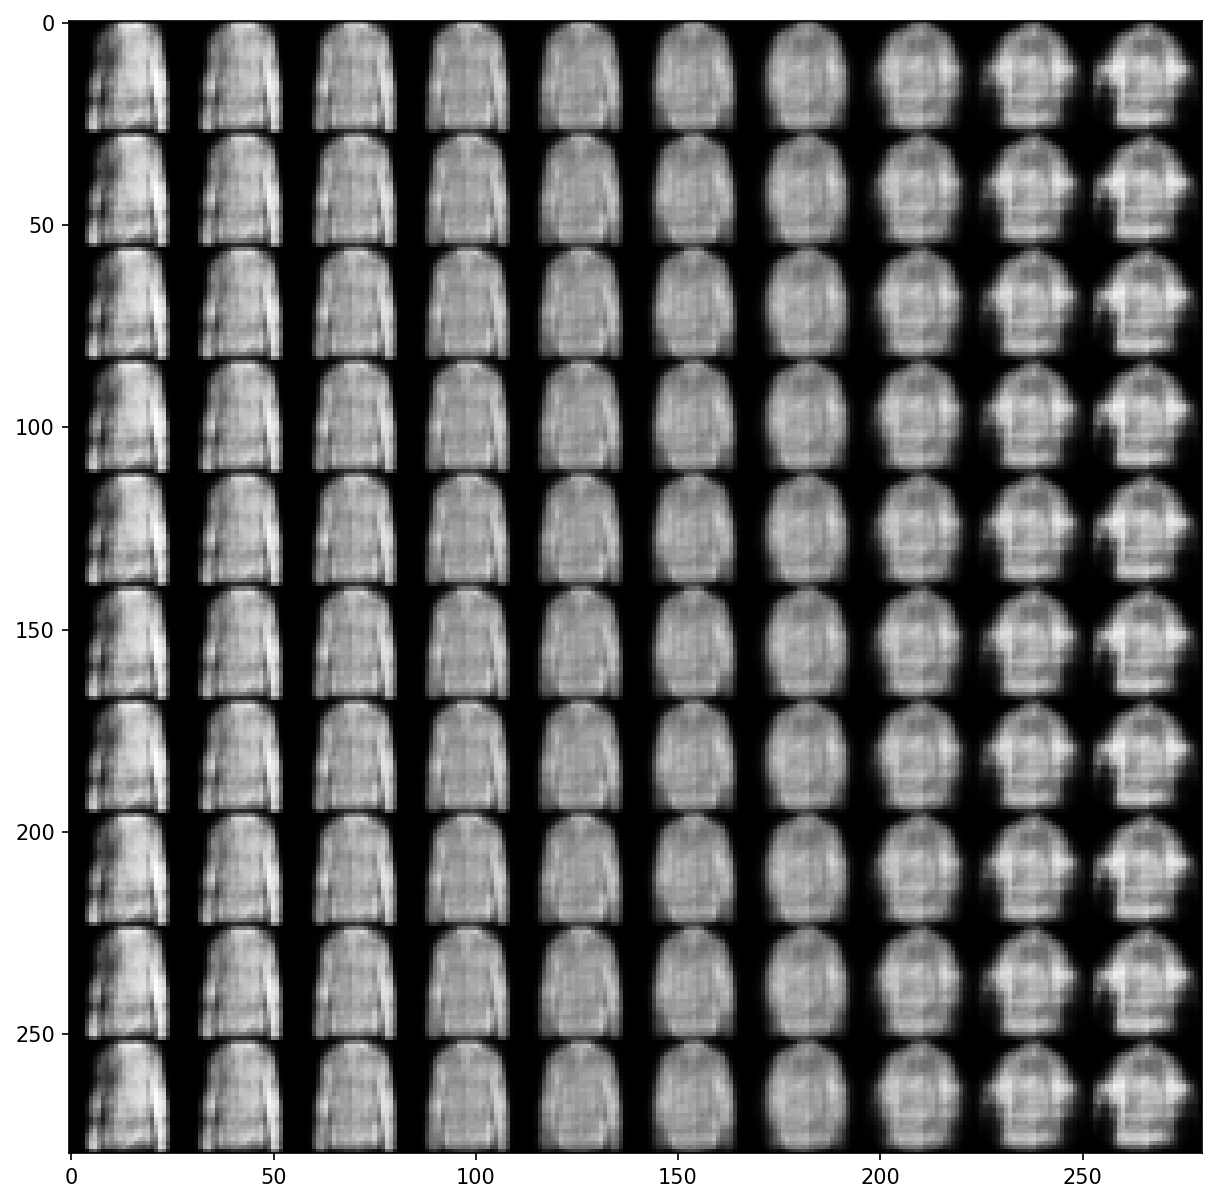

In [311]:
# code adapted from Hamidreza Saghir at https://github.com/hsaghir/VAE_intuitions
from scipy.stats import norm
n=10
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x = np.arange(-3,3.2, 6/9, dtype='float32')
grid_y = grid_x

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[0,0,0,0,0,0,xi,0,0,xi]])
        x_decoded=variational_decoder_beta(z_sample)
        digit=np.reshape(x_decoded,[28,28])
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [272]:
for i in np.arange(-3,3.2, 6/9, dtype='float32'):
    print(i)

-3.0
-2.3333333
-1.6666665
-0.99999976
-0.33333302
0.33333373
1.0000005
1.666667
2.333334
3.000001


In [233]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

In [235]:
for i, yi in enumerate(grid_x):
    print(yi)

-1.6448536269514729
-1.204046960026702
-0.920822976368379
-0.697141434846342
-0.5039653672113454
-0.3280721075316513
-0.16184416680396227
-1.3914582123358836e-16
0.16184416680396213
0.3280721075316511
0.5039653672113453
0.6971414348463417
0.9208229763683788
1.2040469600267016
1.6448536269514722


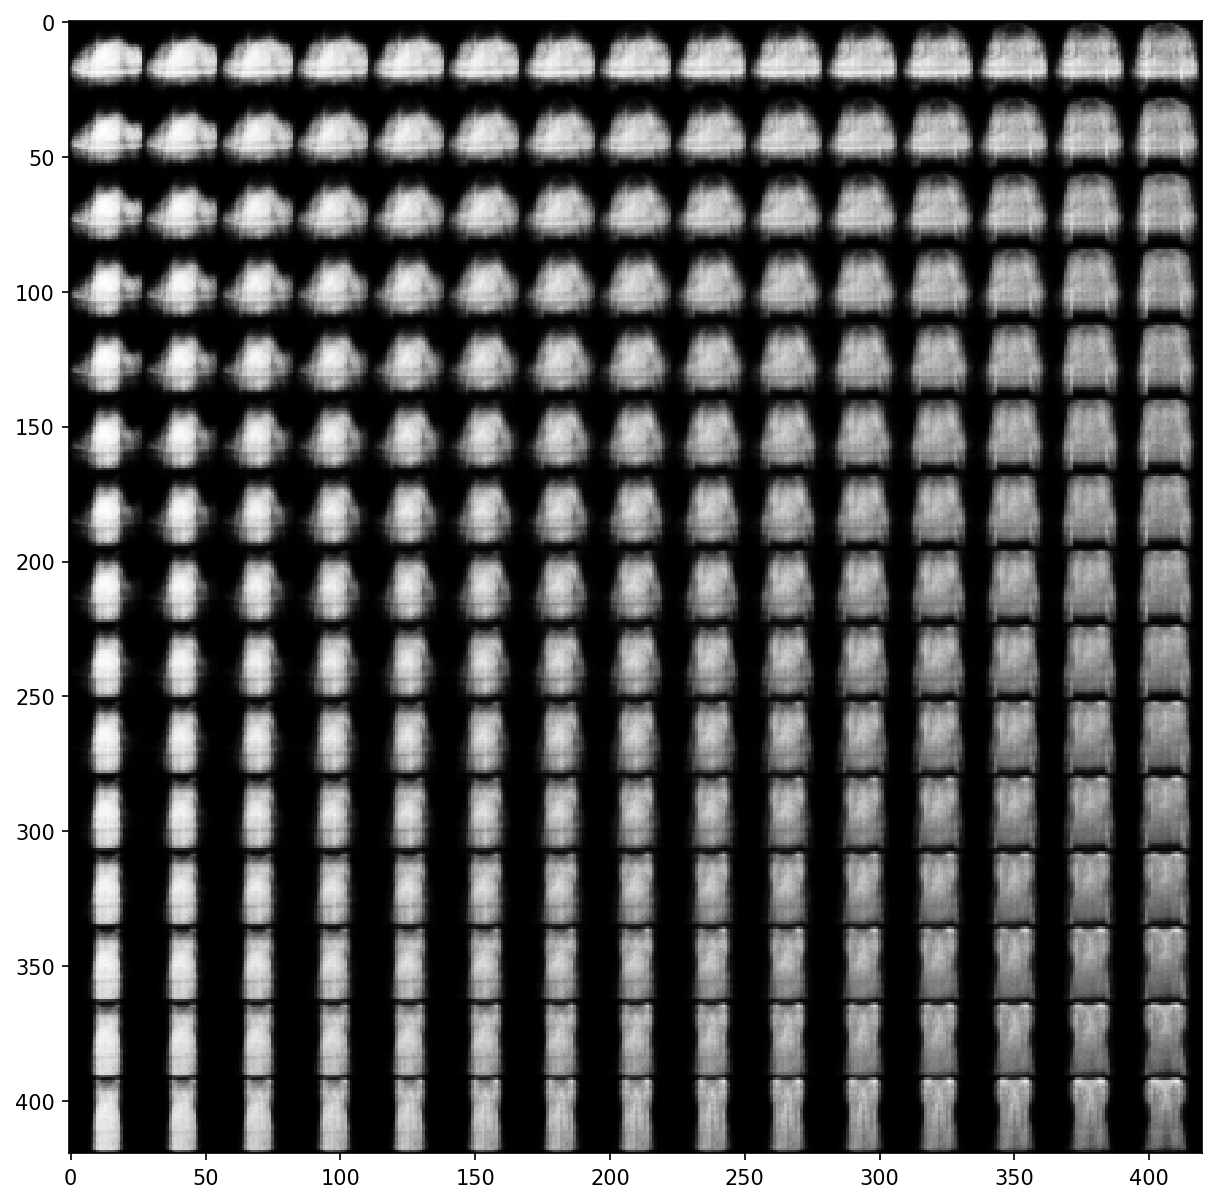

In [232]:
# code modified from Hamidreza Saghir at https://github.com/hsaghir/VAE_intuitions
from scipy.stats import norm
n=15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[0,yi,0,xi,0,0,0,0,0,0]])
        x_decoded=variational_decoder_beta(z_sample)
        digit=np.reshape(x_decoded,[28,28])
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# plot the results
def plot_single_reconstruction(model, coding): 
    reconstructions = model.predict(coding)
    
    # get the length of index_list to set number of
    # images to plot
    # Plot a random sample
    fig, axes = plt.subplots(1, 1,figsize=(1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    axes[0].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
    axes[0][i].axis('off')
    axes[0][i].set_title(str(index_list[i]))
    axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
    axes[1][i].axis('off')
        
    plt.show()